<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Network Solution for ODE with Hill-Type Nonlinearity
**Goal**: Numerically solve an ODE with a Hill-type nonlinearity using DeepXDE.

- **Equation**: `dx/dt = x^(1/\u03b1) / (b^(1/\u03b1) + x^(1/\u03b1))`
- **Context**:
  - This is not the classical Hill equation but contains a Hill-type function.
  - This form appears in simplified gene regulation models.
- **Conditions**:
  - $ \alpha \to 0 $ (small, stiff regime)
  - $ x(0) \approx b $ (initial condition close to $b$)
- **Method**:
  - Physics-Informed Neural Network (PINN) with a 4-layer FNN (tanh activations).
  - Adam optimizer (LR=0.001).
- **Output**: Predicted `x(t)` compared with an approximate analytical solution.

In [ ]:
# Parameters
alpha = 0.01
b = 1.0
x0 = b * 0.99999  # Начальное условие x(0) ≈ b

!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Compiling model...
Building feed-forward neural network...
'build' took 0.117573 s

'compile' took 0.655095 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.19e-04, 1.00e+00]    [5.19e-04, 1.00e+00]    []  
100       [1.20e-03, 1.61e-03]    [1.21e-03, 1.61e-03]    []  
200       [6.47e-04, 1.62e-03]    [6.51e-04, 1.62e-03]    []  
300       [4.95e-04, 1.54e-03]    [4.98e-04, 1.54e-03]    []  
400       [4.15e-04, 1.49e-03]    [4.18e-04, 1.49e-03]    []  
500       [3.69e-04, 1.45e-03]    [3.71e-04, 1.45e-03]    []  
600       [3.51e-04, 1.42e-03]    [3.53e-04, 1.42e-03]    []  
700       [3.51e-04, 1.40e-03]    [3.52e-04, 1.40e-03]    []  
800       [3.56e-04, 1.39e-03]    [3.57e-04, 1.39e-03]    []  
900       [3.59e-04, 1.38e-03]    [3.59e-04, 1.38e-03]    []  
1000      [3.59e-04, 1.38e-03]    [3.60e-04, 1.38e-03]    []  
1100      [3.59e-04, 1.38e-03]    [3.59e-04, 1.38e-03]    []  
1200      [3.57e-04, 1.38e-03]    [3.57e-04,

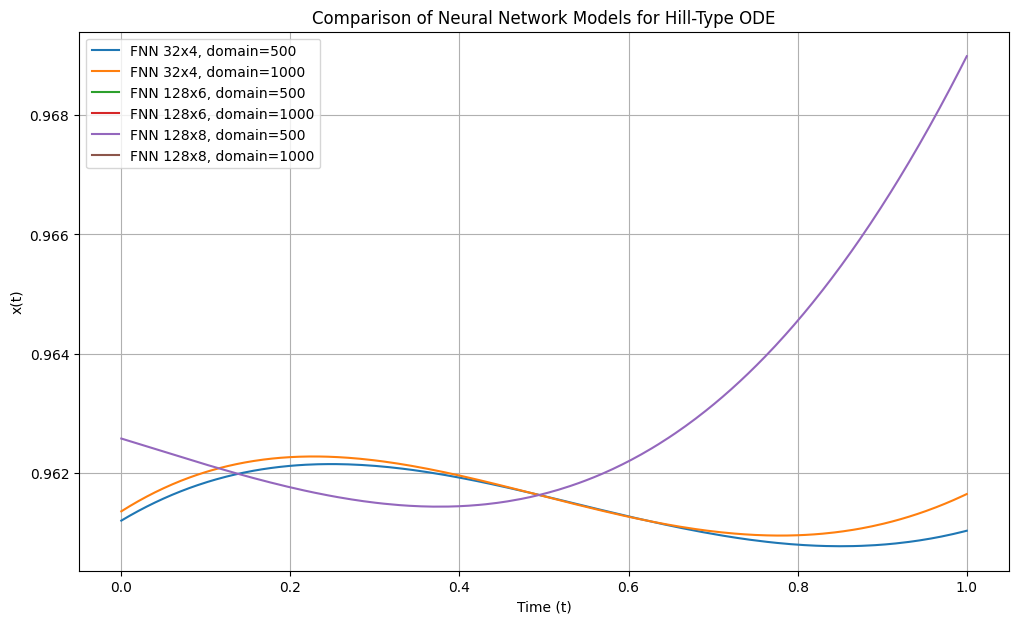

In [9]:
# Solution of ODE with Hill-like RHS: model comparison and approximation

# ODE with Hill-like RHS
def hill_type_ode(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)
    x_alpha = tf.pow(y, 1 / alpha)
    b_alpha = tf.pow(b, 1 / alpha)
    return dy_t - x_alpha / (b_alpha + x_alpha)

# Time domain geometry
geom = dde.geometry.TimeDomain(0, 1)

# Initial condition: x(0) ≈ b
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Configurations to compare
configs = [
    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
    (500, [1] + [128] * 6 + [1], "FNN 128x6, domain=500"),
    (1000, [1] + [128] * 6 + [1], "FNN 128x6, domain=1000"),
    (500, [1] + [128] * 8 + [1], "FNN 128x8, domain=500"),
    (1000, [1] + [128] * 8 + [1], "FNN 128x8, domain=1000")
]

# Prepare test time points
t_test = np.linspace(0, 1, 500).reshape(-1, 1)

# Plot all models
plt.figure(figsize=(12, 7))

for num_domain, architecture, label in configs:
    data = dde.data.PDE(
        geom,
        hill_type_ode,
        ic,
        num_domain=num_domain,
        num_boundary=4,
        num_test=500
    )

    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)
    model.train(iterations=3000, display_every=100)

    x_pred = model.predict(t_test)
    plt.plot(t_test, x_pred, label=label)

# Finalize plot for model comparison
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models for Hill-Type ODE")
plt.legend()
plt.grid(True)
plt.show()

# ⚡ Approximate Solution with Heaviside Step Function  
This code solves the same ODE using an explicit Heaviside step-function approximation for the limit case when $\alpha \to 0$.  
It gives a simple, interpretable solution used for comparison with neural network predictions.  


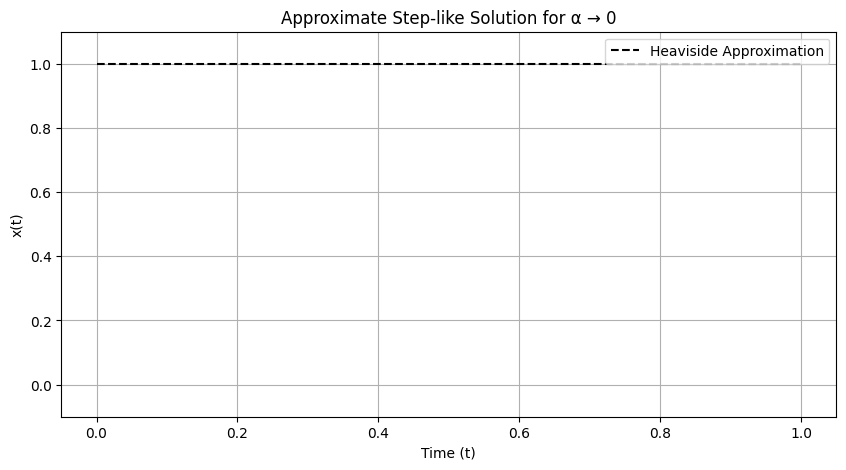

In [10]:
# Approximate solution using Heaviside step function

# Step-like approximation: x(t) = b for t >= 0
x_heaviside = b * (t >= 0)

# Determine y-limits dynamically from other models
ymin = -0.1
ymax = b + 0.1

# Plot Heaviside approximation
plt.figure(figsize=(10, 5))
plt.plot(t, x_heaviside, 'k--', label='Heaviside Approximation')
plt.ylim([ymin, ymax])
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Approximate Step-like Solution for α → 0")
plt.legend()
plt.grid(True)
plt.show()

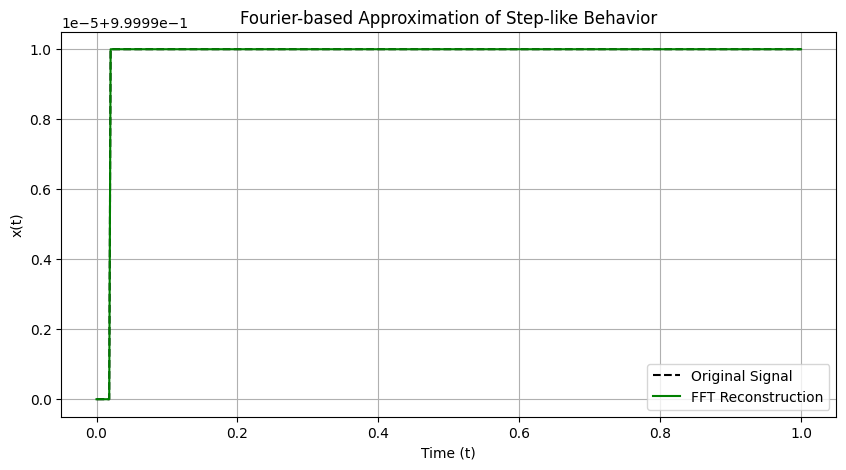

In [11]:
# Fourier approximation using SciPy

from scipy.fftpack import fft, fftfreq, ifft

# Generate example signal (synthetic sharp step)
t_signal = np.linspace(0, 1, 500)
x_signal = np.ones_like(t_signal) * b
x_signal[:10] = x0  # emulate sharp rise near t=0

# Perform FFT
fft_coeffs = fft(x_signal)
reconstructed = np.real(ifft(fft_coeffs))

# Plot FFT-based reconstruction
plt.figure(figsize=(10, 5))
plt.plot(t_signal, x_signal, 'k--', label='Original Signal')
plt.plot(t_signal, reconstructed, 'g-', label='FFT Reconstruction')
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Fourier-based Approximation of Step-like Behavior")
plt.legend()
plt.grid(True)
plt.show()